In [255]:
import time
import numpy as np
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from flax.training import train_state

In [193]:
t_c = jnp.array([0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0])
t_u = jnp.array([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])
t_c = t_c[..., jnp.newaxis]
t_u = jnp.expand_dims(t_u, 1)

t_c.shape, t_u.shape

((11, 1), (11, 1))

In [194]:
def get_random_key():
  """Generates a new random key for each call."""
  seed = int(time.time() * 1000) 
  return jax.random.key(seed)

In [195]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = jax.random.permutation(get_random_key(), n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(Array([ 1,  4, 10,  2,  8,  5,  7,  0,  6], dtype=int32),
 Array([3, 9], dtype=int32))

In [196]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [197]:
linear_model = nnx.Linear(in_features=1, out_features=1, rngs=nnx.Rngs(0))
linear_model(t_un_val)

Array([[15.186794],
       [11.200029]], dtype=float32)

In [198]:
linear_model.kernel

Param(
  value=Array([[1.8543093]], dtype=float32)
)

In [199]:
linear_model.bias

Param(
  value=Array([0.], dtype=float32)
)

In [200]:
x = jnp.ones(1)
linear_model(x)

Array([1.8543093], dtype=float32)

In [201]:
x = jnp.ones((10, 1))
linear_model(x)

Array([[1.8543093],
       [1.8543093],
       [1.8543093],
       [1.8543093],
       [1.8543093],
       [1.8543093],
       [1.8543093],
       [1.8543093],
       [1.8543093],
       [1.8543093]], dtype=float32)

In [243]:
class TrainState(train_state.TrainState):
  graphdef: nnx.GraphDef

In [289]:
graphdef, params = nnx.split(linear_model, nnx.Param)

In [290]:
state = TrainState.create(
  apply_fn=None,
  graphdef=graphdef,
  params=params,
  tx=optax.sgd(1e-2))

In [291]:
@jax.jit
def train_step(state: nnx.TrainState, batch):
  x, y = batch

  def loss_fn(params):
    model = nnx.merge(state.graphdef, params)
    y_pred = model(x)
    loss = optax.losses.squared_error(predictions=y_pred, targets=y).mean()
    return loss
  
  loss, grads = jax.value_and_grad(loss_fn)(state.params)
  state = state.apply_gradients(grads=grads)
  ## SGD from scratch
  # params = jax.tree.map(lambda w, g: w - 0.1 * g, params, grads)
  
  return loss, state

In [292]:
@jax.jit
def test_step(state: nnx.TrainState, batch):
  x, y = batch
  model = nnx.merge(state.graphdef, state.params)
  y_pred = model(x)
  loss = jnp.mean((y - y_pred) ** 2)
  return {'loss': loss}

In [293]:
n_epochs = 3000

for epoch in range(1, n_epochs + 1):
  loss_train, state = train_step(state, (t_un_train, t_c_train))

  if epoch == 1 or epoch % 1000 == 0:
    logs = test_step(state, (t_un_val, t_c_val))
    print(f"Epoch {epoch}, Training loss {loss_train:.4f},"
          f" Validation loss {logs['loss']:.4f}")

Epoch 1, Training loss 24.8128, Validation loss 75.2284
Epoch 1000, Training loss 3.9652, Validation loss 8.6205
Epoch 2000, Training loss 2.9072, Validation loss 4.1459
Epoch 3000, Training loss 2.8523, Validation loss 3.5954


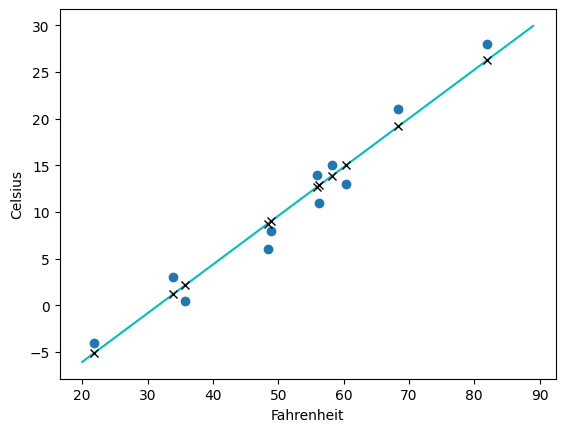

In [294]:
t_range = jnp.arange(20., 90.)[..., None]

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u, t_c, 'o')
plt.plot(t_range, nnx.merge(state.graphdef, state.params)(0.1 * t_range), 'c-')
plt.plot(t_u, nnx.merge(state.graphdef, state.params)(0.1 * t_u), 'kx')
plt.show()

In [250]:
class SeqModel(nnx.Module):
  def __init__(self, din, dhidden, dout, *, rngs: nnx.Rngs):
    self.hidden_linear = nnx.Linear(din, dhidden, rngs=rngs)
    self.output_linear = nnx.Linear(dhidden, dout, rngs=rngs)

  def __call__(self, x):
    x = self.hidden_linear(x)
    x = nnx.tanh(x)
    x = self.output_linear(x)
    return x
  
seq_model = SeqModel(1, 13, 1, rngs=nnx.Rngs(0))
seq_model

SeqModel(
  hidden_linear=Linear(
    kernel=Param(
      value=Array(shape=(1, 13), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(13,), dtype=float32)
    ),
    in_features=1,
    out_features=13,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x11470b920>,
    bias_init=<function zeros at 0x113d6f920>,
    dot_general=<function dot_general at 0x11369d120>
  ),
  output_linear=Linear(
    kernel=Param(
      value=Array(shape=(13, 1), dtype=float32)
    ),
    bias=Param(
      value=Array([0.], dtype=float32)
    ),
    in_features=13,
    out_features=1,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x11470b920>,
    bias_init=<function zeros at 0x113d6f920>,
    dot_general=<function dot_general at 0x11369d120>
  )
)

In [251]:
seq_params = nnx.state(seq_model, nnx.Param)
seq_params

State({
  'hidden_linear': {
    'bias': VariableState(
      type=Param,
      value=Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
    ),
    'kernel': VariableState(
      type=Param,
      value=Array([[-0.49798158,  1.6884631 , -0.7463181 , -0.52964056,  0.6734688 ,
              -0.78850216, -1.0442387 , -0.11063416, -0.42331228,  0.41268215,
              -0.19413577,  0.43233663,  0.71943283]], dtype=float32)
    )
  },
  'output_linear': {
    'bias': VariableState(
      type=Param,
      value=Array([0.], dtype=float32)
    ),
    'kernel': VariableState(
      type=Param,
      value=Array([[ 0.35934874],
             [-0.01674489],
             [ 0.25967693],
             [-0.5509369 ],
             [-0.24052937],
             [-0.4552123 ],
             [-0.2140172 ],
             [ 0.30891147],
             [ 0.11720062],
             [-0.06226148],
             [-0.22391668],
             [ 0.4279803 ],
             [-0.07482409]], dtype=floa

In [252]:
jax.tree.map(jnp.shape, seq_params)

State({
  'hidden_linear': {
    'bias': VariableState(
      type=Param,
      value=(13,)
    ),
    'kernel': VariableState(
      type=Param,
      value=(1, 13)
    )
  },
  'output_linear': {
    'bias': VariableState(
      type=Param,
      value=(1,)
    ),
    'kernel': VariableState(
      type=Param,
      value=(13, 1)
    )
  }
})

In [253]:
seq_model.output_linear.bias

Param(
  value=Array([0.], dtype=float32)
)

In [282]:
graphdef, params = nnx.split(seq_model, nnx.Param)

In [283]:
optimizer = optax.sgd(learning_rate=1e-3)
opt_state = optimizer.init(params)

In [284]:
@jax.jit
def train_step(params, opt_state, graphdef, batch):
  x, y = batch

  def loss_fn(params):
    model = nnx.merge(graphdef, params)
    y_pred = model(x)
    loss = optax.losses.squared_error(predictions=y_pred, targets=y).mean()
    return loss

  loss, grad = jax.value_and_grad(loss_fn)(params)
  updates, opt_state = optimizer.update(grad, opt_state)
  params = optax.apply_updates(params, updates)

  return loss, params, opt_state

In [285]:
@jax.jit
def test_step(params, graphdef, batch):
  x, y = batch
  model = nnx.merge(graphdef, params)
  y_pred = model(x)
  loss = jnp.mean((y - y_pred) ** 2)
  return {'loss': loss}

In [286]:
n_epochs = 5000

for epoch in range(1, n_epochs + 1):
  loss_train, params, opt_state = \
    train_step(params, opt_state, graphdef, (t_un_train, t_c_train))

  if epoch == 1 or epoch % 1000 == 0:
    logs = test_step(params, graphdef, (t_un_val, t_c_val))
    print(f"Epoch {epoch}, Training loss {loss_train:.4f},"
          f" Validation loss {logs['loss']:.4f}")

Epoch 1, Training loss 114.7493, Validation loss 446.7541
Epoch 1000, Training loss 4.5596, Validation loss 37.7680
Epoch 2000, Training loss 3.0941, Validation loss 20.0431
Epoch 3000, Training loss 2.3566, Validation loss 12.4853
Epoch 4000, Training loss 2.0051, Validation loss 8.5606
Epoch 5000, Training loss 1.8461, Validation loss 6.6060


In [287]:
print('output', nnx.merge(graphdef, params)(t_un_val))
print('answer', t_c_val)
print('hidden', nnx.merge(graphdef, params).hidden_linear.kernel)

output [[25.41354 ]
 [15.553859]]
answer [[28.]
 [13.]]
hidden Param(
  value=Array([[-0.6269858 ,  1.6869128 , -0.72232056, -0.520648  ,  0.6069046 ,
          -0.2606868 , -1.008883  ,  0.3054991 , -0.25107768,  0.26034996,
          -0.3672691 ,  0.48064238,  0.6510663 ]], dtype=float32)
)


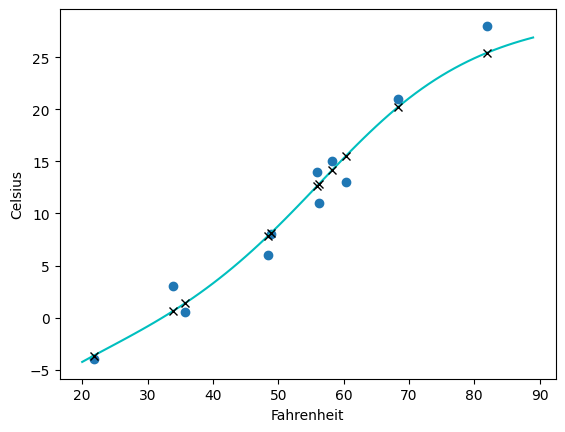

In [288]:
t_range = jnp.arange(20., 90.)[..., None]

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u, t_c, 'o')
plt.plot(t_range, nnx.merge(graphdef, params)(0.1 * t_range), 'c-')
plt.plot(t_u, nnx.merge(graphdef, params)(0.1 * t_u), 'kx')
plt.show()